In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as layers
import numpy as np
#import math
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Generate the data

according to:

x ~ N((0,0), [[1, -0.5],[-0.5, 1]]) when Y == 0

x ~ N((1,1+z), [[1,0],[0,1]]) when Y == 1

where Z has a Gaussian prior z ~ N(0,1)

/Users/zgubic/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


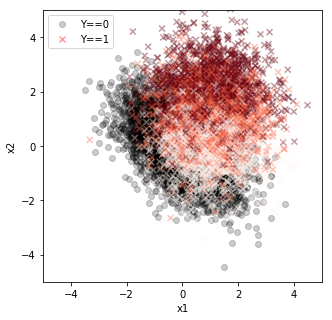

In [2]:
# generate variates
def generate(n_samples):
    Y = np.zeros(n_samples)
    Y[n_samples//2:] = 1

    #Z = np.random.normal(0, 2, size=n_samples)
    Z = np.random.choice([-1,0,1], n_samples)

    X0 = np.random.multivariate_normal([0, 0], [[1, -0.5],[-0.5, 1]], size=n_samples//2)
    X1 = np.random.multivariate_normal([1, 1], np.eye(2), size=n_samples//2)
    X1[:,1] += Z[n_samples//2:]
    X = np.concatenate([X0, X1])
    return X, Y, Z

def plot_variates(X, Y, Z):
    n_samples = X.shape[0]
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(X[Y==0,0], X[Y==0,1], marker='o', color='k', alpha=0.2, label='Y=0')
    ax.scatter(X[Y==1,0], X[Y==1,1], marker='x', c=Z[n_samples//2:], alpha=0.4, cmap='Reds', label='Y=1')
    ax.set_ylim(-5, 5)
    ax.set_xlim(-5, 5)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    leg = ax.legend(loc='best')
    leg.legendHandles[1].set_color('red')
    fig.show()
    
n_samples = 10000
X, Y, Z = generate(n_samples)
plot_variates(X, Y, Z)

# Train a classifier without the adversary

Trains a classifier f(X) that gives p(f(X)) which depends on Z, i.e. p(f(X)|Z=z). 

In [3]:
def classifier(x_in, y_in, name):
    with tf.variable_scope(name):
        # define the output of the network
        dense1 = layers.relu(x_in, 20)
        dense2 = layers.relu(dense1, 20)
        output = layers.linear(dense2, 1)
        # define the loss and optimisation steps
        y_shaped = tf.reshape(y_in, shape=(n_samples, 1))
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_shaped, logits=output))
        opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)
    
    these_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)
    
    return output, loss, opt, these_vars

In [4]:
sess = tf.InteractiveSession()

/Users/zgubic/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/zgubic/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


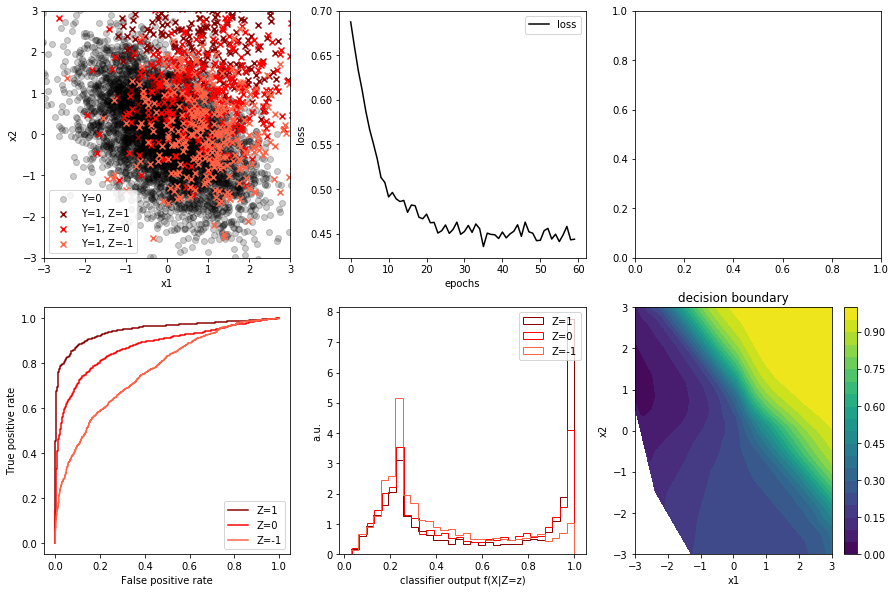

In [59]:
def sigmoid(x):
    return 1 / (1 + np.e**(-x))

def plot_classifier(generate, n_samples, n_epochs, name):
    
    x_in = tf.placeholder(tf.float32, shape=[n_samples, 2], name='X1_X2')
    y_in = tf.placeholder(tf.float32, shape=[n_samples, ], name='Y')
    
    # create the graph
    output, loss, opt, clf_vars = classifier(x_in, y_in, name)
    
    # train it
    losses = []
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epochs):
        X, Y, Z = generate(n_samples)
        feed_dict = {x_in:X, y_in:Y}
        _, l, out = sess.run([opt, loss, output], feed_dict=feed_dict)
        losses.append(l)

    # define figure (plot grid)
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    lim=3
    
    # plot the variates
    N = 300
    ax[0,0].scatter(X[Y==0,0], X[Y==0,1], marker='o', color='k', alpha=0.2, label='Y=0')
    mask1 = np.logical_and(Y==1,Z==1)
    ax[0,0].scatter(X[mask1,0][:N], X[mask1,1][:N], marker='x', c='darkred', alpha=1, label='Y=1, Z=1')
    mask0 = np.logical_and(Y==1,Z==0)
    ax[0,0].scatter(X[mask0,0][:N], X[mask0,1][:N], marker='x', c='red', alpha=1, label='Y=1, Z=0')
    mask_1 = np.logical_and(Y==1,Z==-1)
    ax[0,0].scatter(X[mask_1,0][:N], X[mask_1,1][:N], marker='x', c='tomato', alpha=1, label='Y=1, Z=-1')
    ax[0,0].set_ylim(-lim, lim)
    ax[0,0].set_xlim(-lim, lim)
    ax[0,0].set_xlabel('x1')
    ax[0,0].set_ylabel('x2')
    leg = ax[0,0].legend(loc='best')
    
    # plot the losses
    ax[0,1].plot(range(len(losses)), losses, c='k', label='loss')
    ax[0,1].set_xlabel('epochs')
    ax[0,1].set_ylabel('loss')
    ax[0,1].legend(loc='best')

    # plot the ROC curves for Z=-1,0,1
    pred = sigmoid(out.ravel())
    fpr1, tpr1, _ = roc_curve(Y[Z==1], pred[Z==1])
    fpr0, tpr0, _ = roc_curve(Y[Z==0], pred[Z==0])
    fpr_1, tpr_1, _ = roc_curve(Y[Z==-1], pred[Z==-1])
    ax[1,0].plot(fpr1, tpr1, c='darkred', label='Z=1')
    ax[1,0].plot(fpr0, tpr0, c='red', label='Z=0')
    ax[1,0].plot(fpr_1, tpr_1, c='tomato', label='Z=-1')
    ax[1,0].legend(loc='best')
    ax[1,0].set_xlabel('False positive rate')
    ax[1,0].set_ylabel('True positive rate')
    
    # plot the probability densities for Z=-1,0,1
    bins=30
    ax[1,1].hist(pred[Z==1], bins=bins, normed=True, color='darkred', histtype='step', label='Z=1')
    ax[1,1].hist(pred[Z==0], bins=bins, normed=True, color='red', histtype='step', label='Z=0')
    ax[1,1].hist(pred[Z==-1], bins=bins, normed=True, color='tomato', histtype='step', label='Z=-1')
    ax[1,1].set_xlabel('classifier output f(X|Z=z)')
    ax[1,1].set_ylabel('a.u.')
    ax[1,1].legend(loc='best')
    
    # plot the decision boundary
    dec = ax[1,2].tricontourf(X[:,0], X[:,1], pred, 20)
    ax[1,2].set_ylim(-lim, lim)
    ax[1,2].set_xlim(-lim, lim)
    ax[1,2].set_title('decision boundary')
    ax[1,2].set_xlabel('x1')
    ax[1,2].set_ylabel('x2')
    plt.colorbar(dec, ax=ax[1,2])
    fig.show()
    plt.savefig('classifier.pdf')
    
plot_classifier(generate, n_samples, 60, 'filter80')